<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/ct_segmentationv06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 문자 인용은 C, C++의 규정을 따른다
### 문자 인용은 '' 를 사용: ex) 'a'
### 문자열 인용은 ""를 사용: ex) "ab"
### 변수명은 문자갯수가 4 조합

# PREPROCESSING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## INSTALL THE REQUIRED MODULE

In [2]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.3 MB/s 


## IMPORT THE MODULES

In [3]:
# DATA PREPROCESSING
from glob import glob
import numpy as np
import pydicom, cv2, os
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from PIL import Image

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import adam_v2

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim

## CREATE THE ROOT PATH

In [4]:
root_paths = []
error_paths = []

In [5]:
workspace_path = "/content/drive/MyDrive/segmentation/data/"

In [6]:
for pt_no in range(1,17): # After, use os.listdir
    pt_idx = "seg_%03d/"%pt_no
    for sr_no in range(1,3): # After, use os.listdir
        idx = "seg_%03d_%d/"%(pt_no,sr_no)
        path = workspace_path + pt_idx + idx
        if os.path.exists(path):
            if len(os.listdir(path+"dicom/")) == 0:
                error_paths.append(path)
            else:
                root_paths.append(path)
        else:
            error_paths.append(path)
            pass

In [7]:
for i, elem in enumerate(root_paths):
    print("IDX: %02d"%(i+1), elem)

IDX: 01 /content/drive/MyDrive/segmentation/data/seg_001/seg_001_1/
IDX: 02 /content/drive/MyDrive/segmentation/data/seg_001/seg_001_2/
IDX: 03 /content/drive/MyDrive/segmentation/data/seg_002/seg_002_1/
IDX: 04 /content/drive/MyDrive/segmentation/data/seg_002/seg_002_2/
IDX: 05 /content/drive/MyDrive/segmentation/data/seg_003/seg_003_1/
IDX: 06 /content/drive/MyDrive/segmentation/data/seg_003/seg_003_2/
IDX: 07 /content/drive/MyDrive/segmentation/data/seg_004/seg_004_1/
IDX: 08 /content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/
IDX: 09 /content/drive/MyDrive/segmentation/data/seg_005/seg_005_2/
IDX: 10 /content/drive/MyDrive/segmentation/data/seg_006/seg_006_1/
IDX: 11 /content/drive/MyDrive/segmentation/data/seg_006/seg_006_2/
IDX: 12 /content/drive/MyDrive/segmentation/data/seg_007/seg_007_1/
IDX: 13 /content/drive/MyDrive/segmentation/data/seg_010/seg_010_1/
IDX: 14 /content/drive/MyDrive/segmentation/data/seg_012/seg_012_1/
IDX: 15 /content/drive/MyDrive/segmentation/data

In [8]:
for i, elem in enumerate(error_paths):
    print("IDX: %02d"%(i+1), elem)

IDX: 01 /content/drive/MyDrive/segmentation/data/seg_004/seg_004_2/
IDX: 02 /content/drive/MyDrive/segmentation/data/seg_007/seg_007_2/
IDX: 03 /content/drive/MyDrive/segmentation/data/seg_008/seg_008_1/
IDX: 04 /content/drive/MyDrive/segmentation/data/seg_008/seg_008_2/
IDX: 05 /content/drive/MyDrive/segmentation/data/seg_009/seg_009_1/
IDX: 06 /content/drive/MyDrive/segmentation/data/seg_009/seg_009_2/
IDX: 07 /content/drive/MyDrive/segmentation/data/seg_010/seg_010_2/
IDX: 08 /content/drive/MyDrive/segmentation/data/seg_011/seg_011_1/
IDX: 09 /content/drive/MyDrive/segmentation/data/seg_011/seg_011_2/
IDX: 10 /content/drive/MyDrive/segmentation/data/seg_015/seg_015_1/
IDX: 11 /content/drive/MyDrive/segmentation/data/seg_015/seg_015_2/


### 경로 설정 - 데이터와 레이블을 불러올 경로를 설정

In [9]:
data_path = ['dicom/','image/','mask/','mask_slicer/','mask_test/','prediction/']

### 훈련 디렉토리와 빈 디렉토리를 저장할 리스트

In [10]:
sel_paths = []

## SSIM을 통한 파일 선택

In [11]:

# root = '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1/mask/'
# file_list = sorted(glob(root+'*.png'))

def create(path='/content/drive/MyDrive/segmentation/data/seg_002/seg_002_1/mask/'):
    '''
    ----------------------------------------
    Purpose: create the file list
    ----------------------------------------
    Usage:
    >> create(path)
    ----------------------------------------
    Input:
    path
    ----------------------------------------
    Output:
    list of image objects(numpy arrays)
    ----------------------------------------
    '''
    root = path
    file_list_2 = sorted(glob(root+'*.png'))
    frame_list = []
    for elem in file_list_2:
        temp_arr = cv2.imread(elem, cv2.IMREAD_UNCHANGED)
        temp_arr = temp_arr -1
        temp_arr = temp_arr * 255
        frame_list.append(temp_arr)
        del temp_arr
    return frame_list, file_list_2
def select(obj_list):
    '''
    ----------------------------------------
    Purpose: decrease the size of input data
    ----------------------------------------
    Usage:
    >> select(array_list)
    ----------------------------------------
    Input:
    list of image objects(numpy arrays)
    ----------------------------------------
    Output:
    list of selected files
    ----------------------------------------
    '''
    n = 0
    cumum = 0
    limit_num = 5
    log_record = []
    selected_file_number = []
    if obj_list != None:
        length = len(obj_list)-1
        for i in range(length):
            n = n + 1
            if i != 0:
                temp_1_obj = np.array(obj_list[i])
                temp_2_obj = np.array(obj_list[i+1])
                result_ssim = ssim(temp_1_obj, temp_2_obj, data_range=255)
                if n < limit_num:
                    if result_ssim < 0.96:
                        out_text = '>> %03d image was     selected. MSSIM = %02.4f: and n is %d. Cumumlative: %d'%(i,result_ssim,n, cumum)
                        print(out_text, end='\r')
                        log_record.append(out_text)
                        selected_file_number.append(i)
                        n = 0
                        cumum = cumum + 1
                    else:
                        out_text = '>> %03d image was not selected. MSSIM = %02.4f: and n is %d. Cumulative: %d'%(i,result_ssim, n, cumum)
                        print(out_text, end='\r')
                        log_record.append(out_text)
                else:
                    out_text = '>> %03d image was     selected. MSSIM = %02.4f: and n is %d. Cumulative: %d'%(i,result_ssim, n, cumum)
                    print(out_text, end='\r')
                    selected_file_number.append(i)
                    n = 0
                    cumum = cumum + 1
            else:
                pass
    else:
        pass
    print(selected_file_number)
    del length, n, temp_1_obj, temp_2_obj, cumum
    return selected_file_number

def save_list(fil_nme, selection_list, pfile_list):
    with open('/content/drive/MyDrive/segmentation/lst_pth/'+fil_nme+'.txt', 'w', encoding='UTF-8') as f:
        for i, line in enumerate(selection_list):
            f.write(str(pfile_list[line] + '\n'))

def main():
    for elem in root_paths:
        list_file = create(path=elem+'/mask_test/')
        # list_file = create()
        temp = select(list_file[0])
        save_list(elem.split('/')[-2], temp, list_file[1])
        del list_file, temp

In [12]:
main()

[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259, 264, 269, 274, 279, 284, 289, 294, 299, 304]
[4, 9, 14, 19, 24, 29, 34, 39, 44, 48, 50, 51, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259, 264, 269, 274, 279, 284, 289, 294, 299, 304, 309, 314, 319, 324, 329, 334, 339, 344, 349, 354]
[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234, 239, 244, 249, 254, 259, 264, 269, 274, 279, 284, 289, 294, 299, 304, 309, 314, 319, 324, 329, 334, 339, 344, 349, 354]
[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 5

In [13]:
text_file_list = glob('/content/drive/MyDrive/segmentation/lst_pth/*.txt')

In [14]:
train_msks_path = []

In [15]:
for elem in text_file_list[:-3]:
    file_objt = open(elem, 'r')
    for line in file_objt:
        train_msks_path.append(line.strip())
    file_objt.close()

In [16]:
train_msks_path

['/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_005.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_010.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_015.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_020.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_025.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_030.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_035.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_040.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_045.png',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//mask_test/seg_001_1_msk_050.png',
 '/content/drive/MyDrive/segmentation/da

In [17]:
train_imgs_path = []

for elem in train_msks_path:
    temp_path = elem[:-31] + "dicom" + elem[-22:-11] + "dcm" + elem[-8:-3] + "dcm"
    train_imgs_path.append(temp_path)

In [18]:
train_imgs_path

['/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_005.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_010.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_015.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_020.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_025.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_030.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_035.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_040.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_045.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dcm_050.dcm',
 '/content/drive/MyDrive/segmentation/data/seg_001/seg_001_1//dicom/seg_001_1_dc

In [19]:
valid_msks_path = []

for elem in text_file_list[-3:]:
    file_objt = open(elem, 'r')
    for line in file_objt:
        valid_msks_path.append(line.strip())
    file_objt.close()

valid_imgs_path = []

for elem in valid_msks_path:
    temp_path = elem[:-31] + "dicom" + elem[-22:-11] + "dcm" + elem[-8:-3] + "dcm"
    valid_imgs_path.append(temp_path)

## CREATE THE PATHS LISTS

### 

## CONFIRM THE PATHS

In [20]:
print('Image numbers: ', len(train_imgs_path))
print('Masks numbers: ', len(train_msks_path))

Image numbers:  1164
Masks numbers:  1164


In [21]:
print('Image numbers: ', len(valid_imgs_path))
print('Masks numbers: ', len(valid_msks_path))

Image numbers:  159
Masks numbers:  159


## CONFIRM THE GPU

In [22]:
!nvidia-smi

Fri Mar 25 05:41:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## CREATE THE TRAIN DATA AND LABELS

In [ ]:
del train_imgs, train_msks

In [24]:
train_imgs = []
for path in train_imgs_path:
    obj = pydicom.dcmread(path)
    arr = obj.pixel_array
    Max_val = np.max(arr)
    Min_val = np.min(arr)
    Up_arr = arr - Min_val
    Dn_arr = Max_val - Min_val
    nor_arr = Up_arr / Dn_arr
    train_imgs.append(nor_arr)
    del obj
train_imgs = np.array(train_imgs)
train_msks = []
for path in train_msks_path:
    temp_obj = Image.open(path)
    temp_arr = np.array(temp_obj)
    train_msks.append(temp_arr)
    del temp_obj
train_msks = np.array(train_msks)

In [25]:
valid_imgs = []
for path in valid_imgs_path:
    obj = pydicom.dcmread(path)
    arr = obj.pixel_array
    Max_val = np.max(arr)
    Min_val = np.min(arr)
    Up_arr = arr - Min_val
    Dn_arr = Max_val - Min_val
    nor_arr = Up_arr / Dn_arr
    valid_imgs.append(nor_arr)
    del obj
valid_imgs = np.array(valid_imgs)
valid_msks = []
for path in valid_msks_path:
    temp_obj = Image.open(path)
    temp_arr = np.array(temp_obj)
    valid_msks.append(temp_arr)
    del temp_obj
valid_msks = np.array(valid_msks)

In [26]:
train_msks = train_msks.astype(np.float32)
train_msks = np.reshape(train_msks, (*train_msks.shape, 1))
train_msks -= 1

In [27]:
valid_msks = valid_msks.astype(np.float32)
valid_msks = np.reshape(valid_msks, (*valid_msks.shape, 1))
valid_msks -= 1

In [ ]:
# import numpy as np

# a = np.load('/content/drive/MyDrive/segmentation/data/train_imgs_comp.npz')
# b = np.load('/content/drive/MyDrive/segmentation/data/train_msks_comp.npz')

# a.files
# train_imgs = a['train_imgs']
# b.files
# train_msks = b['a']

## CONFIRM THE TRAIN DATA ND LABELS

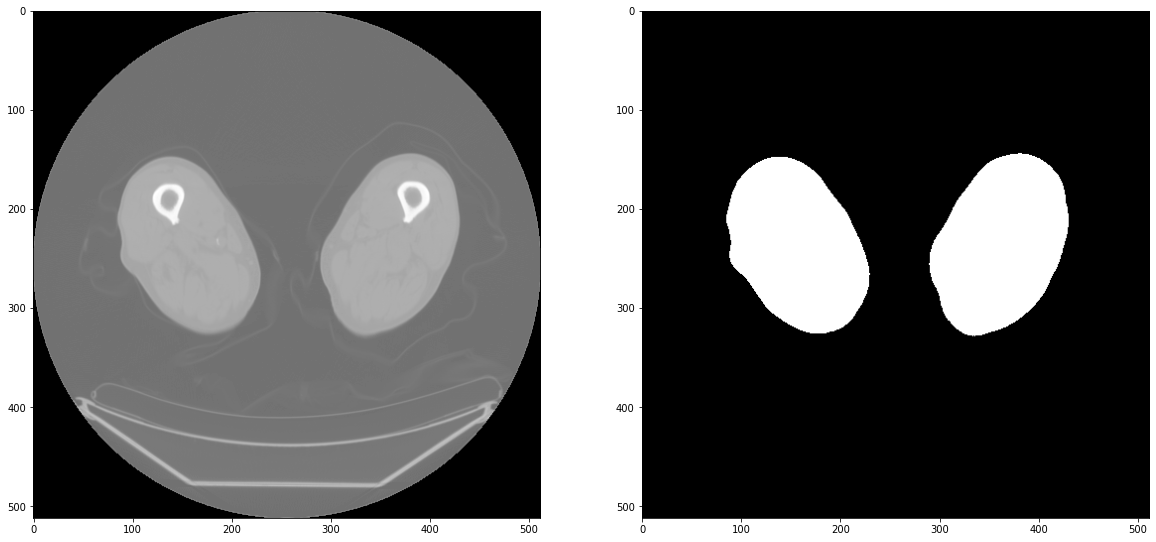

In [28]:
%matplotlib inline

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[700], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[700]), cmap='gray')

# TENSORFLOW

## CONSTRUCT THE MODEL (U_NET)

In [29]:
inputs = Input((512, 512, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

## CUSTOM OBJECTS

In [30]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

## COMPILE

In [31]:
model.compile(adam_v2.Adam(learning_rate=1e-4), bce_dice_loss, metrics=[binary_crossentropy, dice_coef])

## TRAIN(FIT)

In [32]:
model.fit(train_imgs, train_msks, batch_size=6, epochs=10, validation_data=(valid_imgs, valid_msks))

Epoch 1/10
194/194 [==============================] - 61s 236ms/step - loss: -0.4792 - binary_crossentropy: 0.3742 - dice_coef: 0.6662 - val_loss: 0.0891 - val_binary_crossentropy: 1.0023 - val_dice_coef: 0.4113
Epoch 2/10
194/194 [==============================] - 45s 230ms/step - loss: -0.6482 - binary_crossentropy: 0.2668 - dice_coef: 0.7816 - val_loss: -0.3280 - val_binary_crossentropy: 0.5381 - val_dice_coef: 0.5962
Epoch 3/10
194/194 [==============================] - 45s 230ms/step - loss: -0.8703 - binary_crossentropy: 0.0991 - dice_coef: 0.9198 - val_loss: -0.2330 - val_binary_crossentropy: 0.7576 - val_dice_coef: 0.6109
Epoch 4/10
194/194 [==============================] - 45s 230ms/step - loss: -0.9475 - binary_crossentropy: 0.0413 - dice_coef: 0.9682 - val_loss: -0.8767 - val_binary_crossentropy: 0.1013 - val_dice_coef: 0.9282
Epoch 5/10
194/194 [==============================] - 45s 230ms/step - loss: -0.9721 - binary_crossentropy: 0.0220 - dice_coef: 0.9831 - val_loss: -0

## SAVE THE TRAINED MODEL

In [ ]:
model.save('my_model_2.h5')

## MODEL VIEW

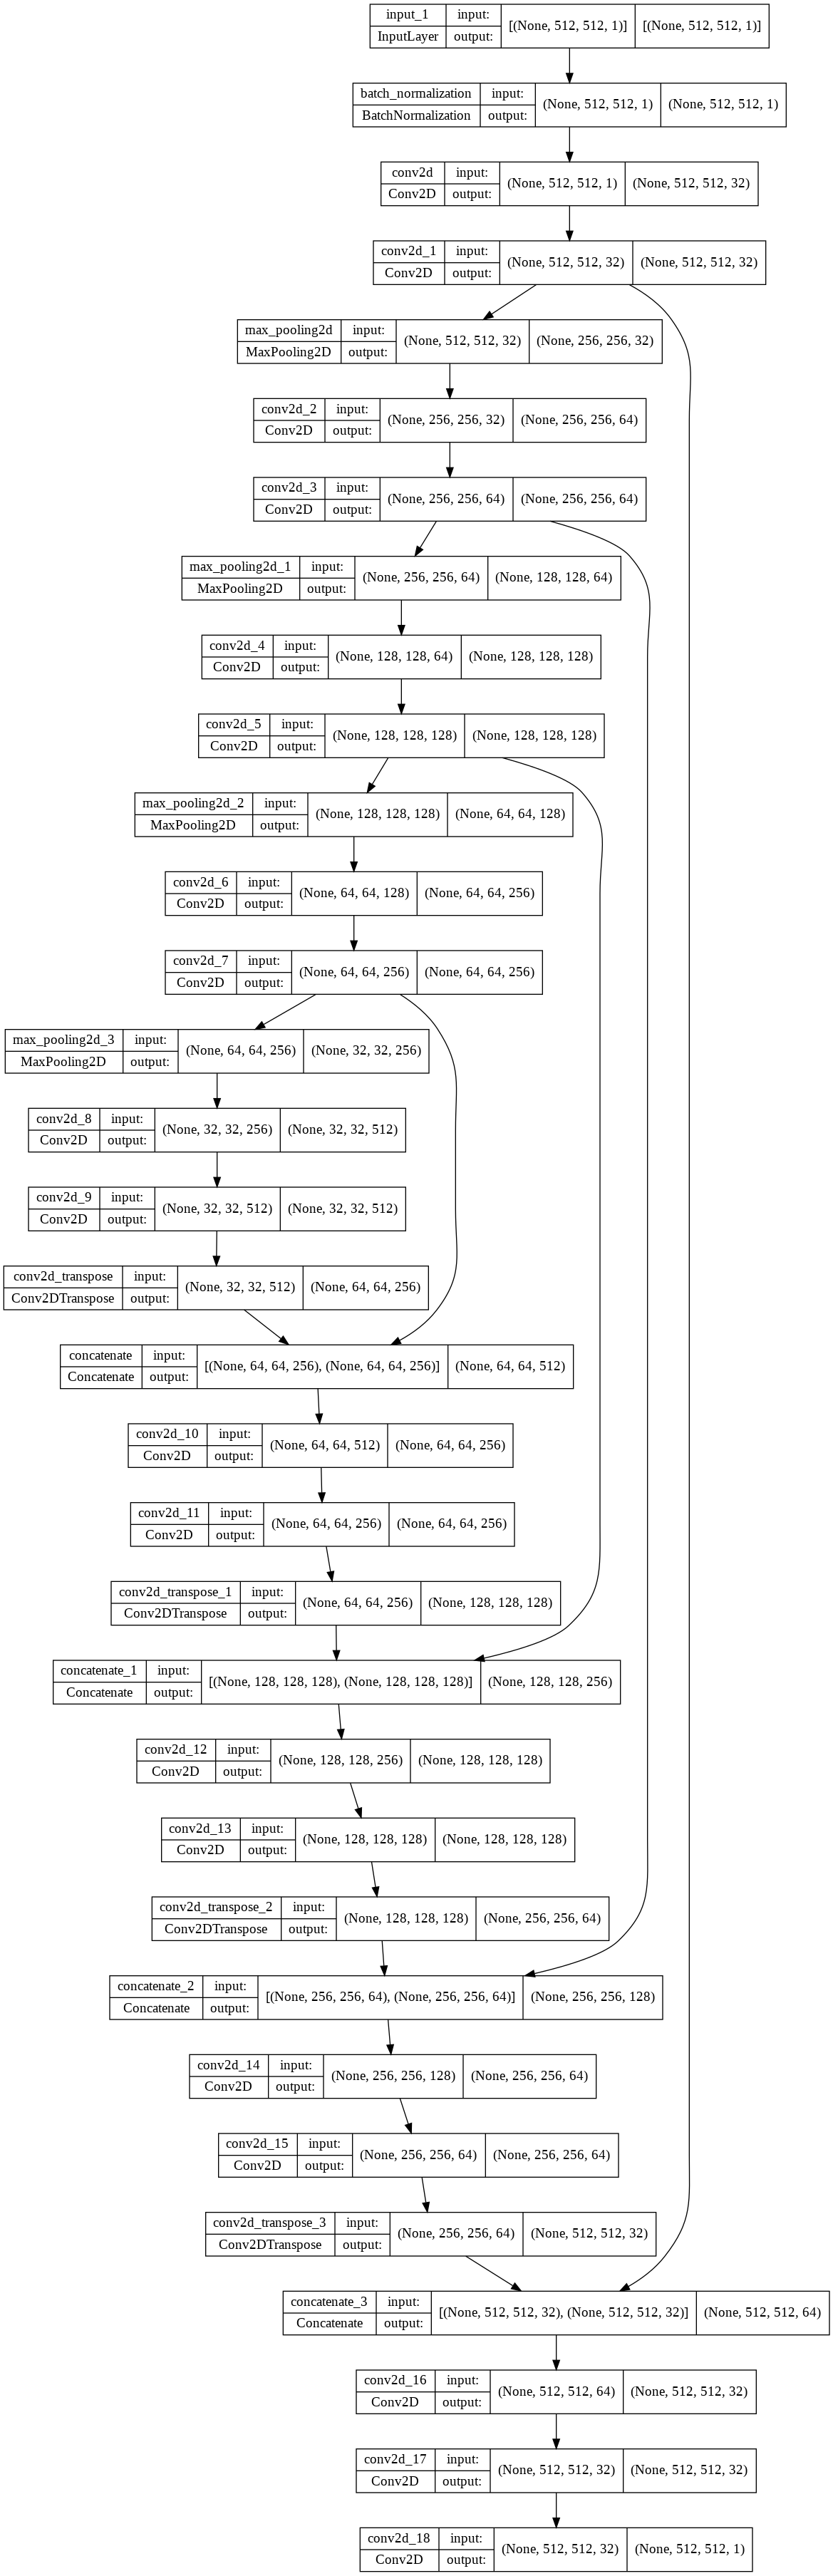

In [33]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [38]:
loss = model.history.history['loss']

In [39]:
val_loss = model.history.history['val_loss']

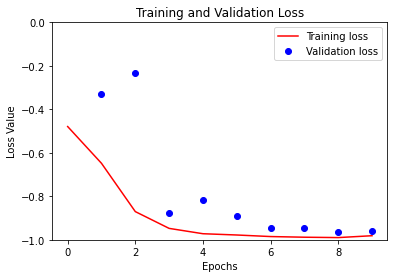

In [42]:
epochs = range(10)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim([-1, 0])
plt.legend()
plt.show()

In [43]:
train_imgs[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [44]:
train_imgs[1].max()

1.0

In [45]:
train_imgs[1].min()

0.0

In [47]:
type(train_imgs[1])

numpy.ndarray

## LOAD THE SAVED MODEL

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/my_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef} )

In [ ]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_cast_single_input',
 '_check_call_args',
 '_ch

In [ ]:
new_model.variables[10]

<tf.Variable 'conv2d_3/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-0.01104455,  0.03655315, -0.00636588, ..., -0.00592034,
           0.05398761,  0.06508172],
         [-0.03101654, -0.02640489, -0.06984399, ..., -0.03272272,
           0.04936585, -0.04094685],
         [ 0.02299531,  0.03673644,  0.05864556, ..., -0.06599463,
           0.03756672,  0.05974183],
         ...,
         [-0.02704668, -0.05902155,  0.05361281, ...,  0.00964891,
           0.0727152 ,  0.04381955],
         [ 0.06081483,  0.06208741, -0.02745816, ...,  0.02297536,
           0.00346905, -0.00221796],
         [ 0.0059637 ,  0.02160623, -0.04697302, ..., -0.01241418,
           0.00735823,  0.01630002]],

        [[-0.06188156,  0.01119879,  0.06105249, ...,  0.05199564,
          -0.02154442, -0.04933621],
         [-0.04915347, -0.05461632, -0.01882896, ...,  0.06122929,
          -0.04081601,  0.01107083],
         [ 0.04078681,  0.04715734,  0.02116137, ..., -0.06013084,
         

In [ ]:
a = new_model.variables[10]

In [ ]:
b = a.numpy()

In [ ]:
sum = 0

for i in b[0][0][0]:
    i = ++i

print(i)


0.06508172


In [ ]:
file_list = sorted(glob(root+idx_path+data_path[1]+'*.jpg'))
predic = []

predic = train_imgs[:10]

for elem in file_list:
    img_obj = cv2.imread(elem, cv2.IMREAD_UNCHANGED)
    predic.append(img_obj)

prediction = np.array(predic)

In [49]:
predictions = np.array(train_imgs[:10])

In [ ]:
pred_imgs = []

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for i in range(1, 357):
    temp_pred = pydicom.dcmread('/content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/dicom/seg_005_1_dcm_%03d.dcm'%i)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

In [ ]:
predictions = np.expand_dims(pred_imgs, axis=3)

## PREDICT

In [51]:
pred_img = model.predict(predictions)

In [52]:
plt_imgs = np.squeeze(pred_img)

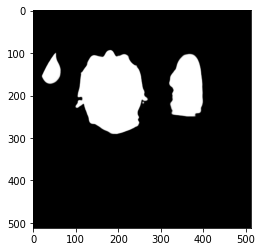

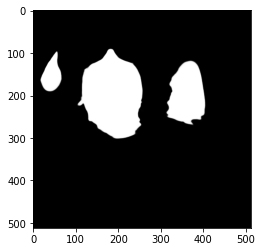

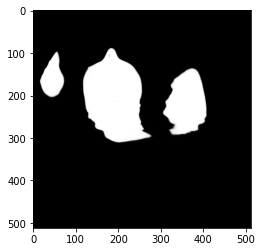

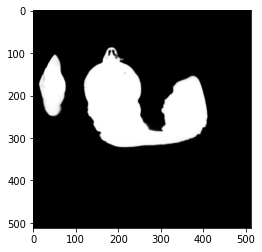

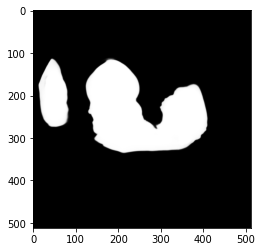

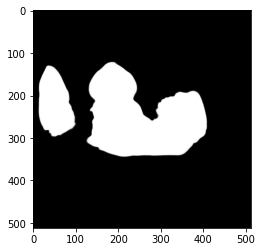

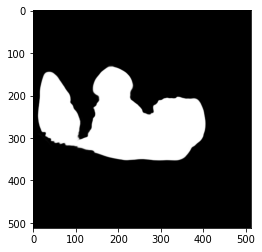

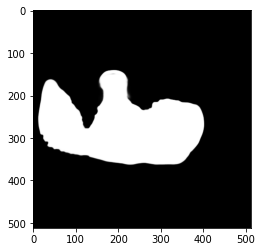

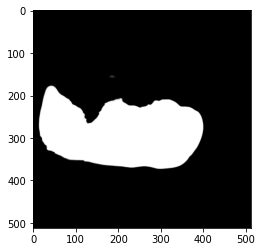

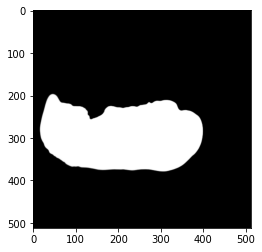

In [53]:
for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()

In [ ]:
for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()

In [ ]:
plt_img = np.squeeze(pred_img[0])

In [ ]:
plt_img[plt_img < 0.5] = 0

In [ ]:
plt_img[plt_img >= 0.5] = 1

In [ ]:
plt.imshow(plt_img, cmap='gray')

In [ ]:
for i, img in enumerate(temp_pred):
    path_ = '/content/drive/MyDrive/segmentation/data/seg_006/mask/mask_1-%03d.png'%(i+1)
    img = img * 255
    cv2.imwrite(path_, img)
    plt.imshow(img)
    plt.show()

In [ ]:
temp_2_pred = []

for elem in temp_pred:
    elem[elem<0.5] = 0
    elem[elem>=0.5] = 1
    elem.astype('uint8')
    temp_2_pred.append(elem)

# PREDICT BY THE LOADED MODEL

### 주의: 모듈을 먼저 임포트 하시오.

In [ ]:
SMOOTH = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + SMOOTH) / (K.sum(y_true_f) + K.sum(y_pred_f) + SMOOTH)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/segmentation/my_model.h5',custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef': dice_coef} )

In [ ]:
pred_imgs = []

def normalize_conf(input_arr):
    Max_val = np.max(input_arr)
    Min_val = np.min(input_arr)
    Up_arr = input_arr - Min_val
    Dn_arr = Max_val - Min_val
    normal_arr = Up_arr / Dn_arr
    return normal_arr

for i in range(1, 357):
    temp_pred = pydicom.dcmread('/content/drive/MyDrive/segmentation/data/seg_005/seg_005_1/dicom/seg_005_1_dcm_%03d.dcm'%i)
    temp_arry = temp_pred.pixel_array
    temp_norm = normalize_conf(temp_arry)
    pred_imgs.append(temp_norm)

pred_imgs = np.array(pred_imgs)

predictions = np.expand_dims(pred_imgs, axis=3)

In [ ]:
pred_img = new_model.predict(predictions)

plt_imgs = np.squeeze(pred_img)

for elem in plt_imgs:
    plt.imshow(elem, cmap='gray')
    plt.show()

In [ ]:
plt_imgs[plt_imgs < 0.5] = 0
plt_imgs[plt_imgs >= 0.5] = 1

In [ ]:
plt_imgs = np.array(plt_imgs, dtype='uint8')

In [ ]:
for i in range(100):
    fig = plt.figure(0, figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(pred_imgs[i], cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(np.squeeze(plt_imgs[i]), cmap='gray')
    plt.show()

### TO DO LIST

1.   폐 윈도우 변환 후 노멀라이즈
2.   모델 저장
3.   



In [ ]:
np.unique(plt_imgs)

array([0, 1], dtype=uint8)